# User-Interface for Res-IRF
The Res-IRF model is a tool for simulating energy consumption for space heating in the French residential sector.

Its main characteristic is to integrate a detailed description of the energy performance of the dwelling stock with a rich description of household behaviour.

This notebook is an example of post-treatment.

In [32]:
import os
import pickle
import matplotlib.pyplot as plt

from ui_utils import *

from parse_input import colors_dict


print(os.getcwd())
os.chdir(os.path.join(os.getcwd(), '..'))
print(os.getcwd())

/Users/lucas/PycharmProjects
/Users/lucas/PycharmProjects/Res-IRF


**User need to enter folder's name:**

In [33]:
# name_folder = '20210604_094019'
name_folder = os.path.join('20210704_131118')

In [34]:
folder_output = os.path.join(os.getcwd(), 'project', 'output', name_folder)
print('Output will be taken from: {}'.format(folder_output))

Output will be taken from: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210704_131118


# Reading input

3 kind of output:
- Buildings stock dynamic and attributes (consumption, heating intensity)
- Renovation
- Detailed subsidies

In [35]:
summary = pd.read_csv(os.path.join(folder_output, 'summary.csv'), index_col=[0])
display(summary)

,Stock,Consumption conventional (kWh),Consumption actual (kWh),Emission (gCO2),Use intensity renovation (%),Renovation rate renovation (%),Flow transition renovation,Capex renovation (€),Subsidies renovation (€),cite (€),cee_subsidy (€),reduced_tax (€),eptz (€)
2018,2.501747e+07,2.675045e+11,1.946836e+11,3.794438e+13,0.791711,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019,2.530305e+07,2.594571e+11,1.903057e+11,3.671411e+13,0.800996,0.031393,767664.327482,1.042697e+10,2.923712e+09,2.239489e+09,2.706199e+08,2.683151e+08,5.602151e+08
2020,2.600130e+07,2.524126e+11,1.867083e+11,3.562822e+13,0.814873,0.031710,770279.829879,1.031339e+10,2.907644e+09,2.269927e+09,2.735983e+08,2.715052e+08,5.709270e+08
2021,2.719533e+07,2.461025e+11,1.838148e+11,3.467602e+13,0.833733,0.032664,788412.512540,1.035390e+10,2.958356e+09,2.398559e+09,2.968168e+08,2.854475e+08,6.031430e+08


In [36]:
output_stock = pickle.load(open(os.path.join(folder_output, 'output_stock.pkl'), 'rb'))
output_transition = pickle.load(open(os.path.join(folder_output, 'output_transition.pkl'), 'rb'))
output_subsidies = pickle.load(open(os.path.join(folder_output, 'output_subsides.pkl'), 'rb'))
output_subsidies_year = pickle.load(open(os.path.join(folder_output, 'output_subsides_year.pkl'), 'rb'))

In [37]:
output_stock.keys()

dict_keys(['Stock - Renovation', 'Stock (m2) - Renovation', 'Consumption conventional (kWh/m2) - Renovation', 'Consumption conventional (kWh) - Renovation', 'Consumption actual (kWh/m2) - Renovation', 'Consumption actual (kWh) - Renovation', 'Budget share (%) - Renovation', 'Use intensity (%) - Renovation', 'Emission (gCO2/m2) - Renovation', 'Emission (gCO2) - Renovation', 'Taxes cost (€/m2) - Renovation', 'Taxes cost (€) - Renovation', 'Stock - Construction', 'Stock (m2) - Construction', 'Consumption conventional (kWh/m2) - Construction', 'Consumption conventional (kWh) - Construction', 'Consumption actual (kWh/m2) - Construction', 'Consumption actual (kWh) - Construction', 'Budget share (%) - Construction', 'Use intensity (%) - Construction', 'Emission (gCO2/m2) - Construction', 'Emission (gCO2) - Construction', 'Taxes cost (€/m2) - Construction', 'Taxes cost (€) - Construction', 'Stock', 'Stock (m2)', 'Consumption conventional (kWh/m2)', 'Consumption conventional (kWh)', 'Consumptio

## Initial dwelling stock

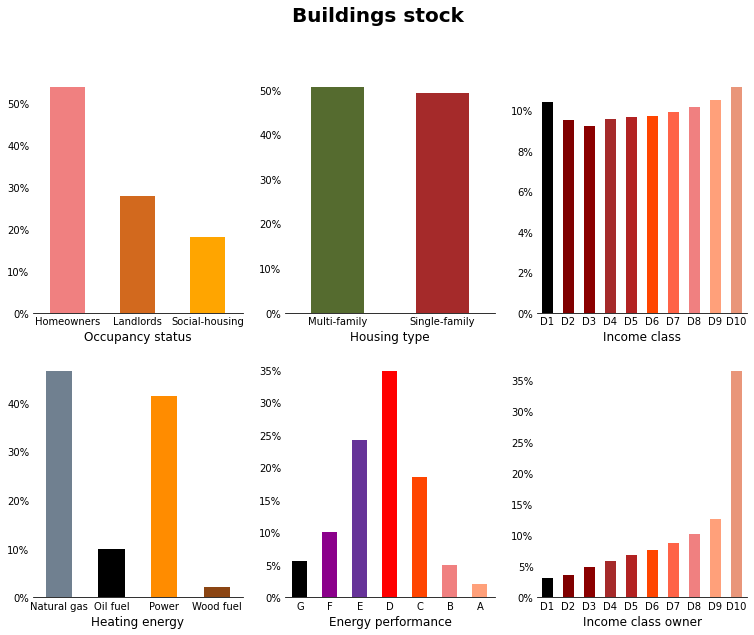

In [38]:
dict_order = {'Energy performance': ['G', 'F', 'E', 'D', 'C', 'B', 'A'], 'Income class': ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10'], 'Income class owner': ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10']}
stock_attributes_subplots(output_stock['Stock - Renovation'].loc[:, 2018], dict_order=dict_order, dict_color=colors_dict)

## Evolution of dwelling stock
Res-IRF considers stock dynamics. Buildings demolition, construction and renovation.

In [44]:
def grouped_and_graph(df, level, level_order=None):
    df = df.groupby([level]).sum()
    if level_order:
        df = df.loc[level_order]
    economic_subplots(df, 'Buildings stock evolution by {}'.format(level.lower()),
                  format_axtitle=lambda x: x, format_val=lambda x: '{:.1f}M'.format(x / 1000000))


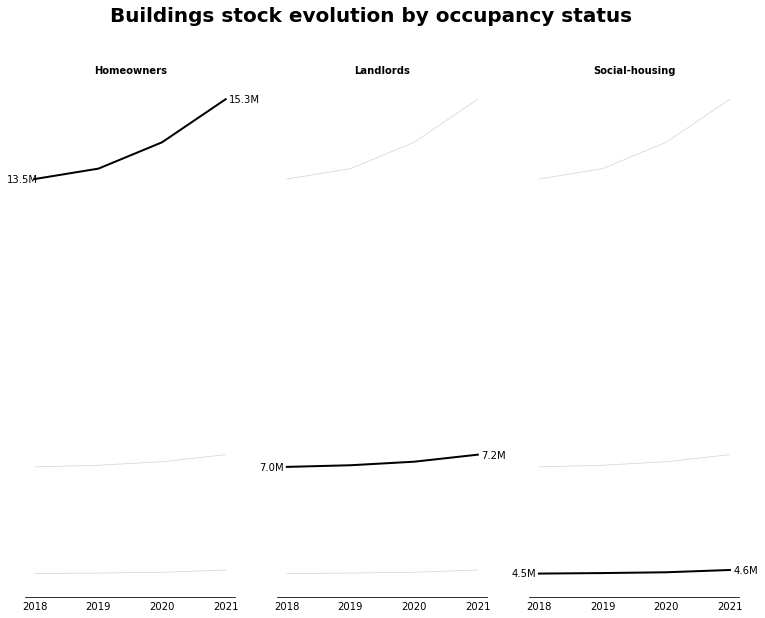

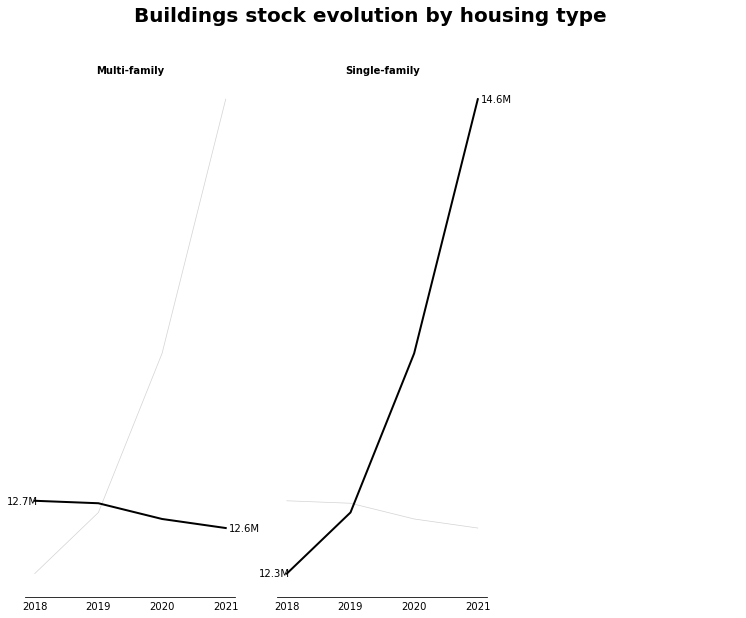

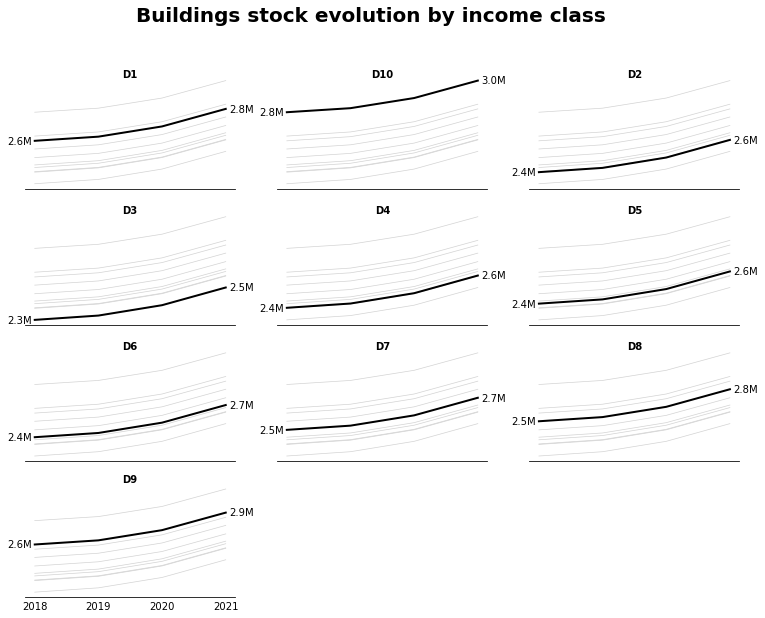

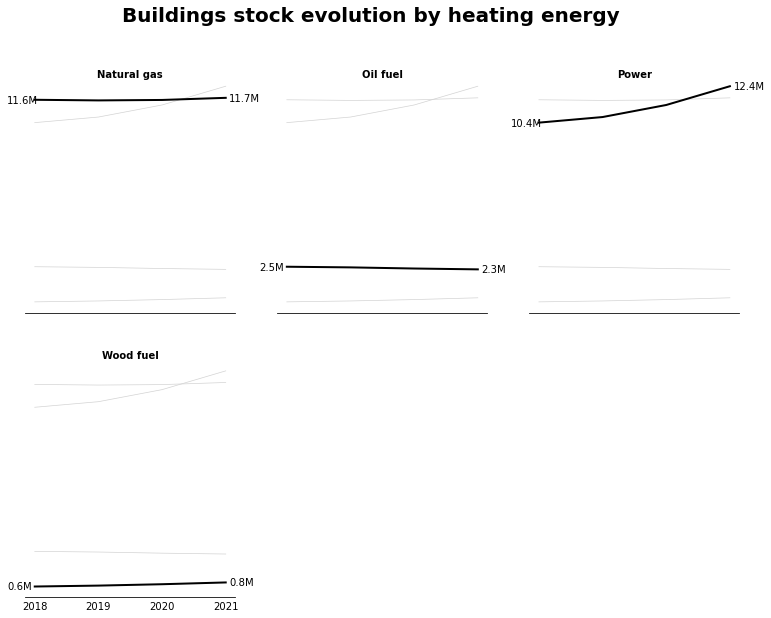

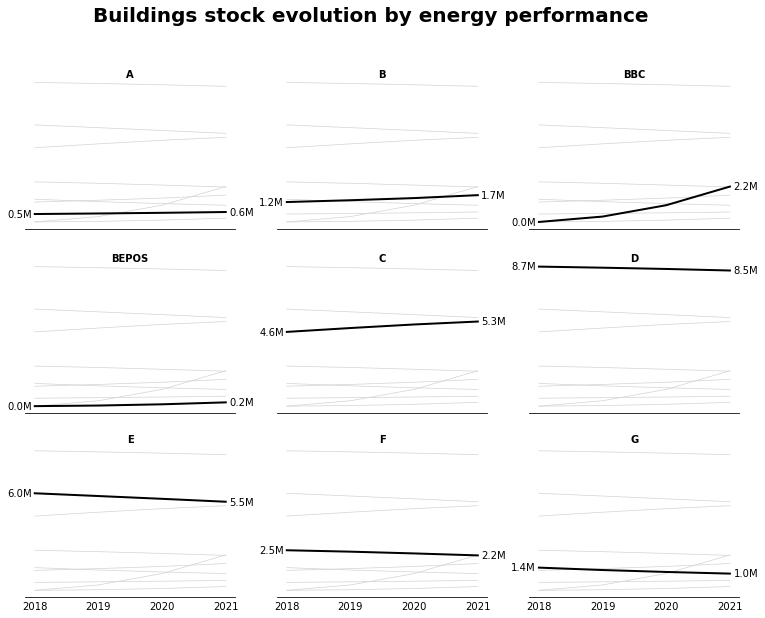

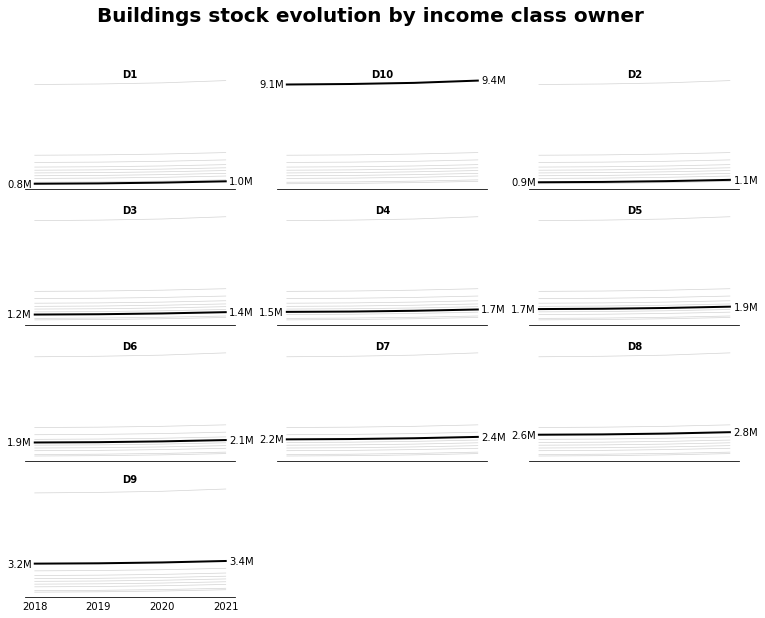

In [46]:
for level in output_stock['Stock'].index.names:
    grouped_and_graph(output_stock['Stock'], level)#, level_order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'BEPOS', 'BBC'])

### Dwellings stocks by attributes

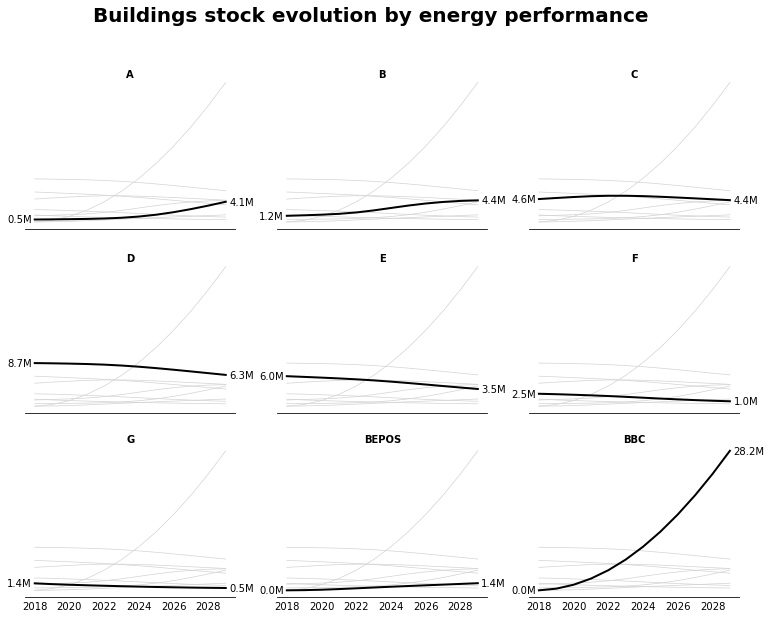

In [6]:
var_dict['stock_construction_segmented'] = var_dict['stock_construction_segmented'].reorder_levels(var_dict['stock_segmented'].index.names)
df = pd.concat((var_dict['stock_segmented'], var_dict['stock_construction_segmented']), axis=0)
df_ep = df.groupby(['Energy performance']).sum()
df_ep = df_ep.loc[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'BEPOS', 'BBC']]
economic_subplots(df_ep, 'Buildings stock evolution by energy performance',
                  format_axtitle=lambda x: x, format_val=lambda x: '{:.1f}M'.format(x / 1000000))

### Dwellings stocks by Heating energy

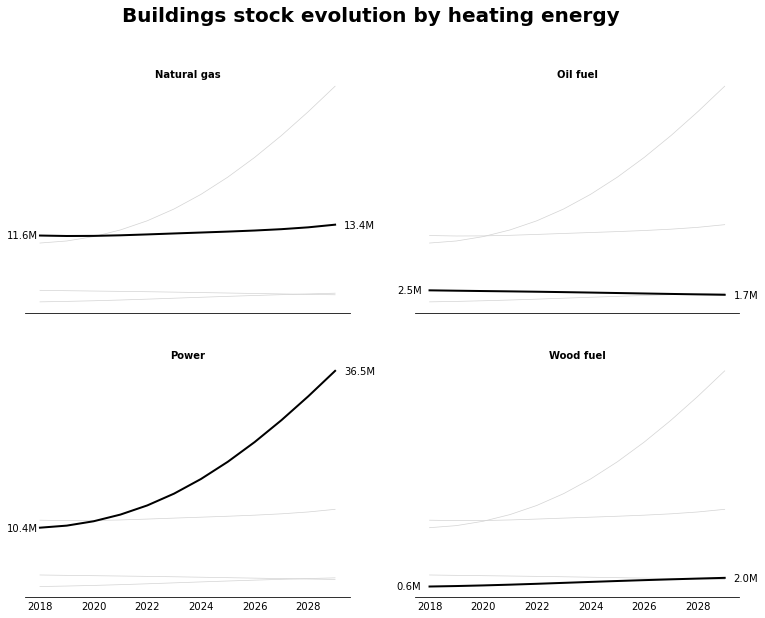

In [7]:
df_ep = df.groupby(['Heating energy']).sum()
economic_subplots(df_ep, 'Buildings stock evolution by heating energy',
                  format_axtitle=lambda x: x, format_val=lambda x: '{:.1f}M'.format(x / 1000000), n_columns=2)

## Energy consumption
Thanks to renovation, demolition and construction, energy consumption tends to decrease over time in the reference case.
Energy consumption actual considers human behavior.

In [8]:
consumption_actual = var_dict['stock_segmented'] * var_dict['consumption_actual']
consumption_actual.dropna(axis=1, how='any', inplace=True)

In [9]:
consumption_actual

2018  \
Occupancy status Housing type  Income class Heating energy Energy performance Income class owner                 
Homeowners       Multi-family  D1           Natural gas    A                  D1                  2.508743e+04   
                                                           B                  D1                  1.714745e+05   
                                                           C                  D1                  1.245748e+06   
                                                           D                  D1                  2.645124e+06   
                                                           E                  D1                  1.949522e+06   
...                                                                                                        ...   
Social-housing   Single-family D9           Wood fuel      C                  D10                 1.974445e+02   
                                                           D                  D10                 9.507972e+02   
                                                           E                  D10                 1.645583e+03   
                                                           F                  D10                 1.169810e+03   
                                                           G                  D10                 5.923575e+02   

                                                                                                          2019  \
Occupancy status Housing type  Income class Heating energy Energy performance Income class owner                 
Homeowners       Multi-family  D1           Natural gas    A                  D1                  2.820164e+04   
                                                           B                  D1                  1.898113e+05   
                                                           C                  D1                  1.269149e+06   
                                                           D                  D1                  2.611805e+06   
                                                           E                  D1                  1.905329e+06   
...                                                                                                        ...   
Social-housing   Single-family D9           Wood fuel      C                  D10                 2.727904e+03   
                                                           D                  D10                 3.107770e+03   
                                                           E                  D10                 2.441740e+03   
                                                           F                  D10                 1.234534e+03   
                                                           G                  D10                 4.980204e+02   

                                                                                                          2020  \
Occupancy status Housing type  Income class Heating energy Energy performance Income class owner                 
Homeowners       Multi-family  D1           Natural gas    A                  D1                  3.172730e+04   
                                                           B                  D1                  2.092457e+05   
                                                           C                  D1                  1.290362e+06   
                                                           D                  D1                  2.578284e+06   
                                                           E                  D1                  1.860482e+06   
...                                                                                                        ...   
Social-housing   Single-family D9           Wood fuel      C                  D10                 5.159673e+03   
                                                           D                  D10                 4.978671e+03   


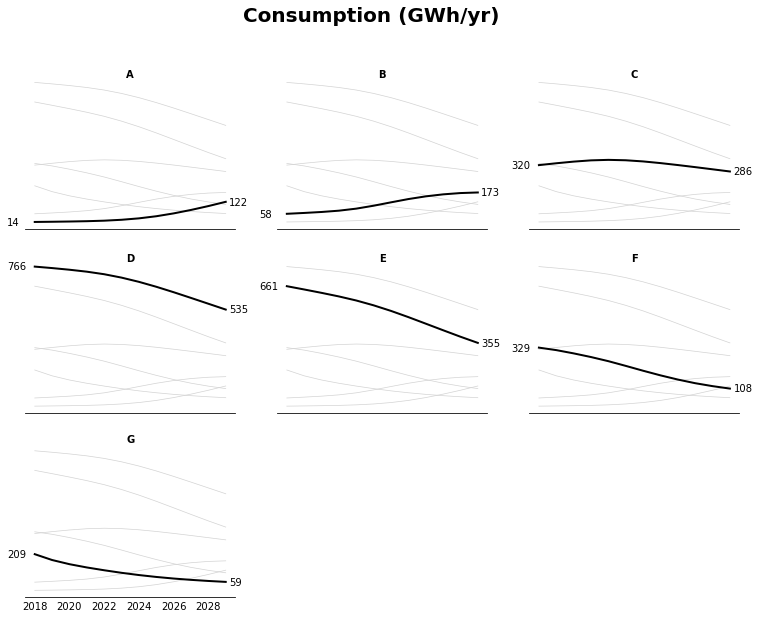

In [10]:
consumption_actual_ep = consumption_actual.groupby('Energy performance').sum()
economic_subplots(consumption_actual_ep, 'Consumption (GWh/yr)',
                  format_axtitle=lambda x: x, format_val=lambda x: '{:.0f}'.format(x / 1000000))

## Capex
Learning-by-doing and information acceleration tends to decrease transition costs.

### Renovation cost

In [11]:
index = var_dict['cost_envelope'].index.get_level_values('Energy performance').unique()
columns = var_dict['cost_envelope'].index.get_level_values('Energy performance final').unique()

In [12]:
from itertools import product


In [13]:
df = var_dict['cost_envelope']
df.head()

2018        2019  \
Energy performance Energy performance final                           
B                  A                         114.691943  109.599460   
C                  A                         207.425592  198.215606   
                   B                          96.966825   92.661362   
D                  A                         282.267299  269.734235   
                   B                         175.749763  167.946227   

                                                   2020        2021  \
Energy performance Energy performance final                           
B                  A                         100.586334   88.492578   
C                  A                         181.914957  160.042850   
                   B                          85.041173   74.816453   
D                  A                         247.552112  217.788280   
                   B                         154.134840  135.602809   

                                                   2022        2023  \
Energy performance Energy performance final                           
B                  A                          74.016490   58.580762   
C                  A                         133.862187  105.945971   
                   B                          62.577578   49.527372   
D                  A                         182.161312  144.172581   
                   B                         113.420178   89.767030   

                                                   2024       2025       2026  \
Energy performance Energy performance final                                     
B                  A                          44.059427  31.714898  22.008676   
C                  A                          79.683476  57.357834  39.803691   
                   B                          37.250243  26.813504  18.607335   
D                  A                         108.434254  78.053246  54.165352   
                   B                          67.515063  48.598756  33.725295   

                                                  2027       2028       2029  
Energy performance Energy performance final                                   
B                  A                         14.818810   9.731841   6.258569  
C                  A                         26.800492  17.600477  11.318907  
                   B                         12.528631   8.227829   5.291336  
D                  A                         36.470439  23.950946  15.402908  
                   B                         22.707806  14.912719   9.590404

In [14]:
df.loc['B', 'A']

2018    114.691943
2019    109.599460
2020    100.586334
2021     88.492578
2022     74.016490
2023     58.580762
2024     44.059427
2025     31.714898
2026     22.008676
2027     14.818810
2028      9.731841
2029      6.258569
Name: (B, A), dtype: float64

In [15]:
coord

NameError: name 'coord' is not defined

In [ ]:
ds = pd.DataFrame([[1, 2], [3, 2], [1, 3]], index=[1, 2, 3], columns=[1, 2])

In [ ]:
df.head()

In [ ]:
df.loc[:, 2018]

In [ ]:
level_x = 'Energy performance'
level_y = 'Energy performance final'
table_plots(var_dict['cost_envelope'], level_x, level_y, suptitle='Renovation cost evolution with learning-by-doing (€/m2)')

In [ ]:
economic_subplots(var_dict['cost_envelope'], 'Renovation cost evolution with learning-by-doing (€/m2)',
                  format_axtitle=lambda x: '{} to {}'.format(x[0], x[1]), format_val=lambda x: '{:.0f}'.format(x))

### Intangible cost

In [ ]:
grouped_ep = var_dict['cost_intangible'].groupby(['Energy performance', 'Energy performance final'])
cost_intangible_ep = grouped_ep.mean()

In [ ]:
economic_subplots(cost_intangible_ep, 'Intangible cost evolution with acceleration information (€/m2)',
                  format_axtitle=lambda x: '{} to {}'.format(x[0], x[1]), format_val=lambda x: '{:.0f}'.format(x))

In [ ]:
# grouped_ep.boxplot(subplots=True)

### Construction cost

In [ ]:
economic_subplots(var_dict['cost_construction'], 'Renovation cost evolution with learning-by-doing (€/m2)',
                  format_axtitle=lambda x: '{} to {}'.format(x[0], x[1]), format_val=lambda x: '{:.0f}'.format(x))

## Total costs
Macro-economic costs: total investment, private investment and public investment.

In [ ]:
data = pd.read_csv(os.path.join(folder_output, 'financials_dict.csv'), index_col=[0])
data.index

In [ ]:
# gCO2/yr --> tCO2/yr
data.loc['Emission saving', :] = data.loc['Emission saving', :] / 1000000
data.loc['Emission total', :] = data.loc['Emission total', :] / 1000000


# kWh/yr --> GWh/yr
data.loc['Energy saving', :] = data.loc['Energy saving', :] / 1000000
data.loc['Consumption total', :] = data.loc['Consumption total', :] / 1000000

In [ ]:
economic_subplots(data.loc[['Investment macro', 'Subsidies macro', 'Private investment macro',], :], 'Investment (G€)', format_val=lambda x: '{:.1f}'.format(x/1000000000))

### Subsidies

In [ ]:
financials_unit = var_dict['result_unit_2019'] 
financials_euro = var_dict['result_euro_2019'] 

In [ ]:
name_file = os.path.join(folder_detailed, 'policies_detailed.pkl')
with open(name_file, 'rb') as handle:
    subsidies_detailed = pickle.load(handle)

In [ ]:
for yr in subsidies_detailed.keys():
    economic_boxplots(subsidies_detailed[yr], ylabel='Possible subsidies (€/m2) {}'.format(yr))
    break

In [ ]:
a = subsidies_detailed[yr].index.names
subsidies_detailed[yr].index.names = a[:-1] + ['Energy performance final']

In [ ]:
b = subsidies_detailed[yr].groupby(['Energy performance', 'Energy performance final']).mean()
economic_subplots(b, 'Subsidies (€/m2)',
                  format_axtitle=lambda x: '{} to {}'.format(x[0], x[1]), format_val=lambda x: '{:.0f}'.format(x))

### CO2 Cost

In [ ]:
co2_graph = pd.DataFrame()
co2_graph['Flow renovation'] = financials_euro['Flow renovation'] * 100000
co2_graph['Emission saving'] = financials_euro['Emission saving'] / 100000
co2_graph['CO2 investment cost'] = financials_euro['CO2 investment cost'] * 100000
co2_graph['CO2 private cost'] = financials_euro['CO2 private cost'] * 100000
co2_graph = co2_graph.sort_values('CO2 private cost')
co2_graph['CO2 Potential Emission'] = co2_graph['Emission saving'].cumsum()

In [ ]:
distribution_scatter(financials_unit, 'Total capex', 'Flow renovation', colors_dict,
                     xlabel='Total capex (€/m2)', ylabel='Renovation', level='Energy performance')

distribution_scatter(financials_unit, 'NPV', 'Flow renovation', colors_dict,
                     xlabel='Total capex (€/m2)', ylabel='Renovation', level='Energy performance')


# Objectives

1. Reduction of final energy consumption by 20% by 2030 and 50% by 2050 compared to 2012 - this objective is applied here to residential heating consumption;
2. Energy renovation of 500,000 homes per year, including 120,000 in social housing;
3. Disappearance of G and F energy performance housing by 2025;
4. Renovation of the entire housing stock to the "low-energy building" level or similar by 2050 - a requirement interpreted here as a minimum performance equal to the B label of the DPE;
5. Reducing fuel poverty by 15% by 2020.

In [ ]:
main_result = pd.read_csv(os.path.join(folder_output, 'financials_dict.csv'), header=[0], index_col=[0])

In [ ]:
main_result

# Interactive

### Interactive table

Interactive table that display information about a specific segment or segments (if multiple value passed).

Widget input:
(can choose one)
- df: financial_unit[year], financial_euro, segment
- yr: optional

(can choose multiple)
- Occupancy status: 
- Housing type: 
- Income class:
- Income class owner:
- Energy performance:
- Heating energy:
- Energy performance final:
- Heating energy final:

In [ ]:
# TODO: if occ=None --> return all
def select_segment(df, occ='Homeowners', housing='Multi-family', income='D5', performance_ini='F', energy_ini='Oil fuel',
                   performance_end='C', energy_end='Oil fuel'):
    # TODO: if one level is not passed, function must returns dataframe. Use multilevels function in old notebook.
    if 'Energy performance final' not in df.index.names:
        return df.xs(occ, level='Occupancy status', drop_level=False).\
            xs(housing, level='Housing type', drop_level=False).\
            xs(income, level='Income class', drop_level=False).\
            xs(performance_ini, level='Energy performance', drop_level=False).\
            xs(energy_ini, level='Heating energy', drop_level=False)
    else:
        return df.xs(occ, level='Occupancy status', drop_level=False).\
            xs(housing, level='Housing type', drop_level=False).\
            xs(income, level='Income class', drop_level=False).\
            xs(performance_ini, level='Energy performance', drop_level=False).\
            xs(energy_ini, level='Heating energy', drop_level=False).\
            xs(performance_end, level='Energy performance final', drop_level=False).\
            xs(energy_end, level='Heating energy final', drop_level=False)


In [ ]:
var_dict.keys()

In [ ]:
output = concat_yearly_dict(var_dict)

In [ ]:
output.keys()

In [ ]:
data = output['flow_renovation_label_energy_dict']

In [ ]:
data.index.names

In [ ]:
mux = pd.MultiIndex.from_arrays([
    list('aaaabbbbbccddddd'),
    list('tuvwtuvwtuvwtuvw')
], names=['Occupancy status', 'two'])

df = pd.DataFrame({'col': np.arange(len(mux))}, mux)

In [ ]:
df

In [ ]:
df.query("Occupancy status == 'a'")

In [ ]:
data

In [ ]:
# slicing with one argumnet
data.loc[['Landlords']]
data.xs('Landlords', level='Occupancy status', axis=0, drop_level=False)
data.query("`Occupancy status` == 'Landlords'")
idx = pd.IndexSlice
data.loc[idx[:, 'Multi-family', :, :, :, :, :, :], :]
data[data.index.get_level_values('Heating energy').isin(['Power', 'Natural gas'])]

items = ['Power', 'Natural gas']
data.query("`Heating energy` in @items")

data.query("`Occupancy status` == 'Landlords' and `Heating energy` in @items")


In [ ]:
# import plotly.graph_objects as go
from ipywidgets import widgets

In [ ]:
w_yrs = widgets.IntSlider(min=2018, max=2030, step=1, description='Years', disabled=False, continuous_update=False)
display(w_yrs)

In [ ]:
w = widgets.Checkbox(value=False, description='Check me', disabled=False, indent=False)
display(w)

In [ ]:
print(w.value)

In [ ]:
housing_type = widgets.Dropdown(options=['Landlords', 'Homeowners', 'Social-housing'], description='Housing type', disabled=False, layout={'width': 'max-content'})
display(housing_type)

In [ ]:
list_heating_energy = ['Power', 'Natural gas', 'Oil fuel', 'Wood fuel']
heating_energy = widgets.Dropdown(options=list_heating_energy, description='Heating energy', disabled=False, layout={'width': 'max-content'})
display(heating_energy)

In [ ]:
multiple = widgets.SelectMultiple(
    options=list_heating_energy,
    value=['Power'],
    description='Heating energy',
    disabled=False
)
display(multiple)

In [ ]:
multiple.value

### Interactive grouped

## Public policies

In [ ]:
Each year, how many subsidies have been given 

In [ ]:
import qgrid

In [ ]:
from itables import init_notebook_mode
from itables import show

# Sensitivity Analysis

Parameters sensitivy analysis:
- cost_invest
- cost_intangible
- nu 
- demolition_rate
- energy_prices 
- public_policies

Almost all need to make a new model calibration --> main_func need to be integrate calibration step
thread(main_func)
